Now that I have full columns, let's make all the summaries in one place

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../annos/adotto_TRannotations_v1.0.txt", sep='\t', header=None)
data.columns = ['chrom', 'start', 'end', 'ovl_flag', 'up_buff', 'dn_buff', 'n_filtered', 'n_annos', 'n_subregions',
          'mu_purity', 'pct_annotated', 'interspersed', 'patho', 'codis', 'annos']

In [102]:
def decode_ovl_flag(m_flag):
    flags = ['i', 'n', 'p', 's']
    # turn to a string
    flag_string = " ".join([f for idx, f in enumerate(flags) 
                            if m_flag & (2 ** idx)])
    return flag_string

In [3]:
# How many regions are in our catalog?
data['span'] = data['end'] - data['start']
tot_span = data['span'].sum()
print(len(data), 'regions covering', tot_span, 'bp', round(tot_span / 3.2e9 * 100, 2), '% of genome')

997179 regions covering 162279447 bp 5.07 % of genome


In [4]:
data['span_bin'] = pd.cut(data['span'],
                          bins=[0, 50, 100, 200, 500, 1000, 2500, 10000, 50000], 
                          labels=["[0,50)", "[50,100)", "[100, 200)", "[200, 500)",
                                  "[500, 1000)", "[1000,2500)", "[2500,10k)", 
                                  "[10k,50k)"])

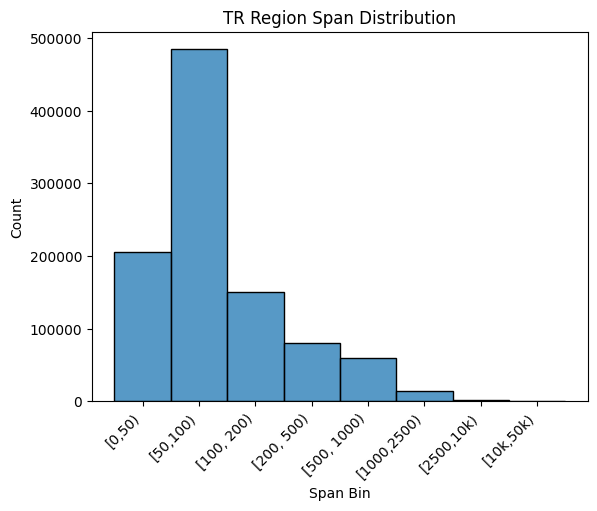

In [5]:
p = sb.histplot(data=data, x='span_bin')
p.set(title="TR Region Span Distribution", xlabel="Span Bin")
hide = plt.xticks(rotation=45, ha='right')

In [6]:
inter = data['interspersed'].value_counts().to_frame().reset_index()
inter.columns = ["Repeat Class", "Count"]
inter['Percent'] = (inter['Count'] / len(data)).round(4)
inter

,Repeat Class,Count,Percent
0,.,903955,0.9065
1,SINE,86194,0.0864
2,LTR,3323,0.0033
3,Retroposon,2066,0.0021
4,LINE,1614,0.0016
5,DNA,27,0.0000


# Filtering out regions with interspersed repeats

In [7]:
# We're just going to filter these for now
data = data[data['interspersed'] == '.'].copy()
tot_span = data['span'].sum()
print(len(data), 'regions covering', tot_span, 'bp', round(tot_span / 3.2e9 * 100, 2), '% of genome')

903955 regions covering 100980982 bp 3.16 % of genome


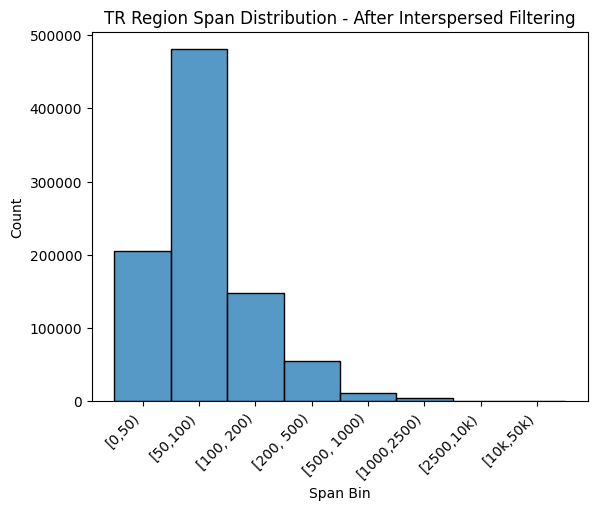

In [8]:
p = sb.histplot(data=data, x='span_bin')
p.set(title="TR Region Span Distribution - After Interspersed Filtering", xlabel="Span Bin")
hide = plt.xticks(rotation=45, ha='right')

In [9]:
# So now let's look at the simplification

In [10]:
ovl_rows = []
cats = ['isolated', 'nested', 'parent', 'staggered']
for i in data['ovl_flag']:
    cur_row = []
    for idx, val in enumerate(cats):
        cur_row.append(val if i & (2**idx) else '.')
    ovl_rows.append(cur_row)
ovl_rows = pd.DataFrame(ovl_rows, columns=cats)
ovl_rows['Count'] = 1

In [16]:
ovl_pvt = pd.pivot_table(ovl_rows, values=['Count'], columns=cats, aggfunc=sum).T
ovl_pvt["Count Percent"] = (ovl_pvt["Count"] / len(ovl_rows)).round(4)
ovl_pvt

Count  Count Percent
isolated nested parent staggered                       
.        .      parent .          115043         0.1273
                       staggered   40243         0.0445
         nested parent .           18868         0.0209
                       staggered   10647         0.0118
isolated .      .      .          543594         0.6014
                       staggered   84852         0.0939
                parent .           44766         0.0495
                       staggered   28961         0.0320
         nested parent .            7304         0.0081
                       staggered    9677         0.0107

In [109]:
# I think the ones that will be 'easier' to compare to will be non-staggered
easier = data[(data['ovl_flag'] & 0x8) == 0].shape
easier, easier[0] / len(data)

((729575, 17), 0.8070921671985885)

In [22]:
best = data[(data["n_subregions"] == 1) & ()]
len(best), len(best) / len(data)

(546282, 0.6043243303040527)

# Let's check out how well our sequences are 'buffered'

[Text(0.5, 0, 'Buffer'), Text(0.5, 1.0, 'Region buffer lengths')]

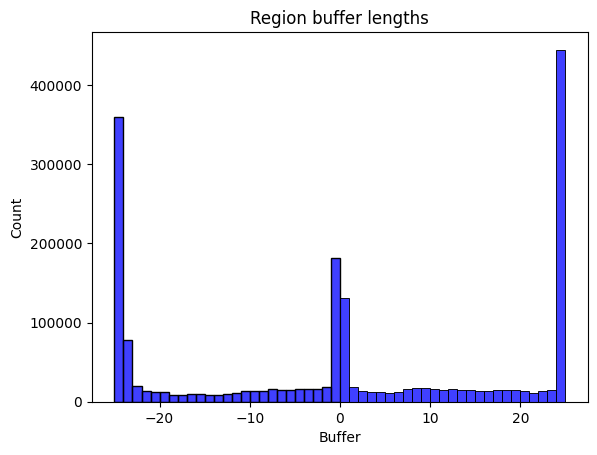

In [24]:
sb.histplot(x=-data['up_buff'], color='blue', binwidth=1)
p = sb.histplot(x=data["dn_buff"], color='blue', binwidth=1)
p.set(xlabel="Buffer", title="Region buffer lengths")

[Text(0.5, 0, 'Buffer'), Text(0.5, 1.0, 'Region buffer ECDF')]

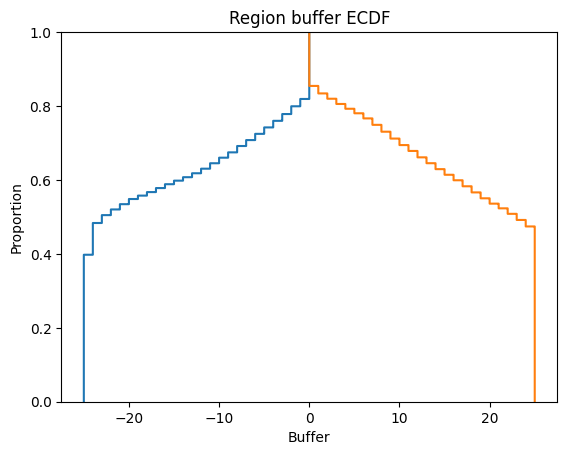

In [25]:
sb.ecdfplot(x=-data['up_buff'])
p = sb.ecdfplot(x=data["dn_buff"], complementary=True)
p.set(xlabel="Buffer", title="Region buffer ECDF")

In [26]:
# 40% have one end with 25bp. Both ends with 25bp is a little worse
rows = []
for i in [5, 10, 20, 25]:
    c = len(data[(data['up_buff'] >= i) & (data['dn_buff'] >= i)])
    rows.append([i, c])
result = pd.DataFrame(rows, columns=["Min Buffer", "Count"])
result['Percent'] = result["Count"] / len(data)
result

,Min Buffer,Count,Percent
0,5,534592,0.591392
1,10,435593,0.481875
2,20,324795,0.359304
3,25,222390,0.246019


[Text(0.5, 1.0, 'ECDF of buffer lengths by overlap flag'),
 Text(0.5, 0, 'Buffer')]

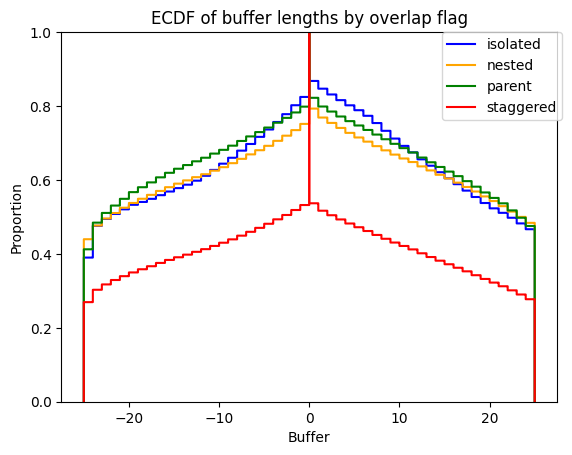

In [110]:
for idx, v in enumerate([('isolated', 'blue'), ('nested', 'orange'),
                                   ('parent', 'green'), ('staggered', 'red')]):
    name, color = v
    view = data[(data['ovl_flag'] & (2**idx)) != 0]
    p = sb.ecdfplot(x=-view["up_buff"], color=color, label=name)
    p = sb.ecdfplot(x=view["dn_buff"], color=color, complementary=True)

plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
p.set(title="ECDF of buffer lengths by overlap flag", xlabel="Buffer")

[Text(0.5, 1.0, 'Buffer by overlap flag'), Text(0.5, 0, 'Buffer')]

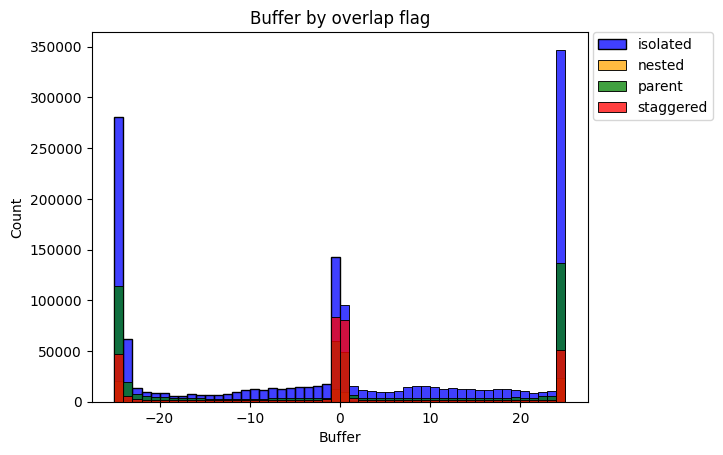

In [32]:
for idx, v in enumerate([('isolated', 'blue'), ('nested', 'orange'),
                                   ('parent', 'green'), ('staggered', 'red')]):
    name, color = v
    view = data[(data['ovl_flag'] & (2**idx)) != 0]
    p = sb.histplot(x=-view["up_buff"], color=color, label=name, binwidth=1, multiple='stack')
    p = sb.histplot(x=view["dn_buff"], color=color, binwidth=1, multiple='stack')

plt.legend(bbox_to_anchor=(1.01, 1), borderaxespad=0)
p.set(title="Buffer by overlap flag", xlabel="Buffer")

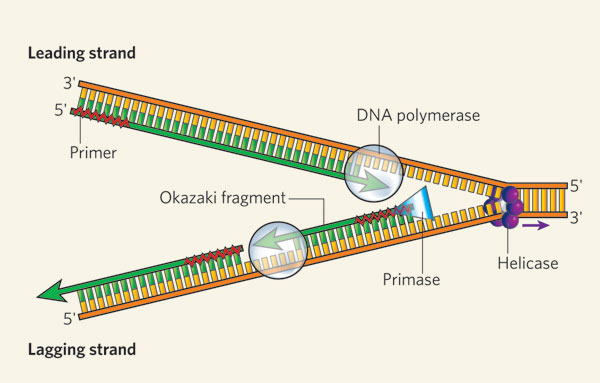

# Other annotations

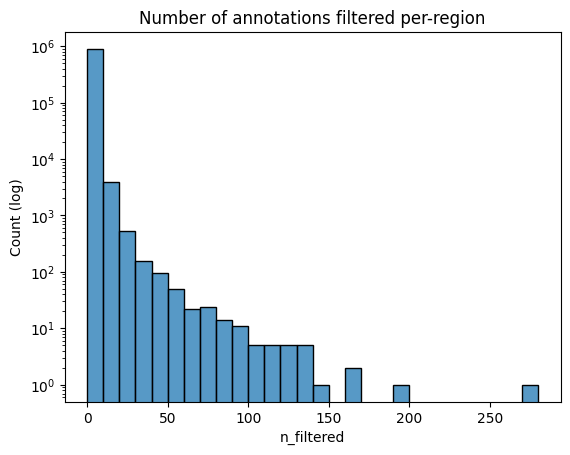

In [42]:
p = p = sb.histplot(data=data, x='n_filtered', binwidth=10)
p.set(yscale='log')
hide = p.set(xlabel='n_filtered', ylabel="Count (log)", title="Number of annotations filtered per-region")

[Text(0.5, 1.0, 'Mean Purity Distribution')]

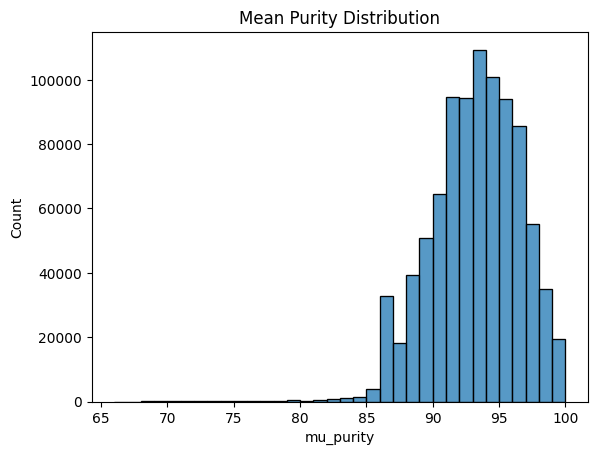

In [33]:
p = sb.histplot(data=data, x="mu_purity", binwidth=1)
p.set(title="Mean Purity Distribution")

[Text(0.5, 1.0, "Percent of region's non-buffer covered by annotations")]

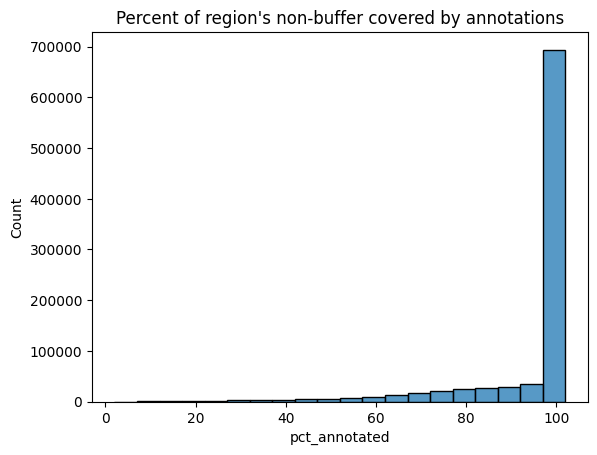

In [34]:
p = sb.histplot(data=data, x="pct_annotated", binwidth=5)
p.set(title="Percent of region's non-buffer covered by annotations")

In [69]:
view = data.melt(value_vars=["n_annos", "n_subregions"])
view.groupby('variable').describe().T

variable           n_annos   n_subregions
value count  903955.000000  903955.000000
      mean        1.518846       1.388996
      std         1.807451       0.876002
      min         1.000000       1.000000
      25%         1.000000       1.000000
      50%         1.000000       1.000000
      75%         2.000000       2.000000
      max       262.000000     191.000000

In [67]:
import sys
view['bin'] = pd.cut(view['value'],
                          bins=[1, 2, 5, 10, sys.maxsize], right=False,
                          labels=["1", "[2,5)", "[5, 10)", "10+"])

[Text(0.5, 1.0, 'Number of annotations/subregions per-region')]

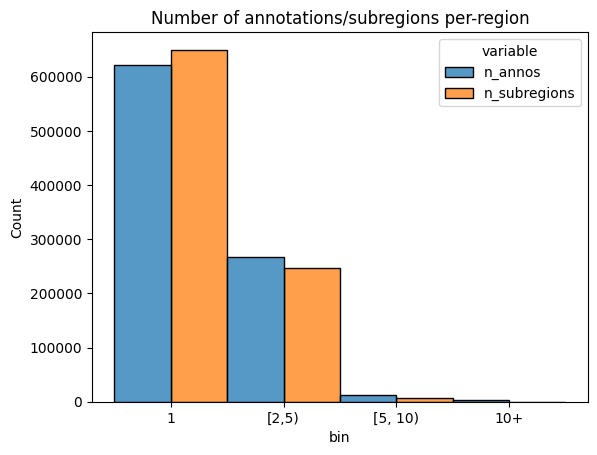

In [68]:
p = sb.histplot(data=view, x='bin', hue="variable", multiple='dodge')
p.set(title="Number of annotations/subregions per-region")

# Patho/Codis

Make sure that all the patho and codis are present.

In [86]:
# Go back to the originals
unfilt = pd.read_csv("../annos/adotto_TRannotations_v1.0.txt", sep='\t', header=None)
unfilt.columns = ['chrom', 'start', 'end', 'ovl_flag', 'up_buff', 'dn_buff', 'n_filtered', 'n_annos', 'n_subregions',
          'mu_purity', 'pct_annotated', 'interspersed', 'patho', 'codis', 'annos']
print('patho_total =', 56)
print('unfilt', unfilt[unfilt['patho'] != '.'].shape)
print('filt', data[data['patho'] != '.'].shape)

patho_total = 56
unfilt (56, 15)
filt (53, 17)


In [87]:
print('codis_total =', 53)
print('unfilt', unfilt[unfilt['codis'] != '.'].shape)
print('filt', data[data['codis'] != '.'].shape)

codis_total = 53
unfilt (51, 15)
filt (51, 17)


In [88]:
# crap
patho = pd.read_csv("../../pathogenic/pathogenic_repeats.hg38.bed", sep='\t', header=None)
patho.columns = ['chrom', 'start', 'end', 'gene']
patho['gene'] = patho['gene'].apply(lambda x: x.split(';')[0][len("ID="):])

codis = pd.read_csv("../../codis/hg38_codis.bed", sep='\t', header=None)
codis.columns = ['chrom', 'start', 'end', 'name']

In [94]:
codis[~codis['name'].isin(data['codis'])]

,chrom,start,end,name
21,chrY,12500448,12500495,DYS389I
22,chrY,12500448,12500611,DYS389II
33,chrY,18888956,18888995,DYS460
34,chrY,18888804,18888851,DYS461


In [92]:
data['codis'].unique()

array(['.', 'D1S1656', 'D10S1248', 'TH01', 'vWA', 'D12S391', 'D13S317',
       'PentaE', 'D16S539', 'D18S51', 'D19S433', 'TPOX', 'D2S441',
       'D2S1338', 'D21S11', 'PentaD', 'D22S1045', 'D3S1358', 'FGA',
       'D5S818', 'CSF1PO', 'SE33', 'D6S1043', 'D7S820', 'D8S1179',
       'DYS393', 'DYS505', 'DYS456', 'DYS570', 'DYS576', 'DYS522',
       'DYS458', 'DYS481', 'DYS19', 'DYS391', 'DYS635', 'DYS437',
       'DYS439', 'DYS389II,DYS389I', 'DYS438', 'DYS612', 'DYS390',
       'DYS643', 'DYS533', 'YGATAH4', 'DYS385b', 'DYS385a',
       'DYS461,DYS460', 'DYS549', 'DYS392', 'DYS448', 'DYF387S1'],
      dtype=object)

So the codis aren't actually missing. They're just overlapping themselves in two chrY loci.

In [99]:
# We're missing 3 pathogenic TRs from the filter
mis_patho = patho[~patho['gene'].isin(data['patho'])]
mis_patho

,chrom,start,end,gene
24,chr2,96197066,96197122,STARD7
32,chr3,129172576,129172732,CNBP
34,chr3,183712187,183712223,YEATS2


In [104]:
j = unfilt[unfilt['patho'].isin(mis_patho['gene'])]
j

,chrom,start,end,ovl_flag,up_buff,dn_buff,n_filtered,n_annos,n_subregions,mu_purity,pct_annotated,interspersed,patho,codis,annos
475203,chr2,96196774,96197458,13,0,25,5,5,5,95,18,SINE,STARD7,.,"[{""chrom"": ""chr2"", ""start"": 96197066, ""end"": 9..."
616682,chr3,129171978,129172783,5,25,25,5,5,5,93,29,SINE,CNBP,.,"[{""chrom"": ""chr3"", ""start"": 129172184, ""end"": ..."
633706,chr3,183711960,183712250,1,25,25,3,2,2,97,28,SINE,YEATS2,.,"[{""chrom"": ""chr3"", ""start"": 183712176, ""end"": ..."


In [106]:
span = (j['end'] - j['start'])
print(span)
span * (j['pct_annotated']/100)

475203    684
616682    805
633706    290
dtype: int64


475203    123.12
616682    233.45
633706     81.20
dtype: float64

Another consequence of the intrahelical nature of SSM is the expectation that
SSM should have an appreciable bias toward the duplication of shorter repeat units;
if the initial event involves local melting and reannealing of the duplex, then a shorter
slippage should be more likely than a longer one, since it distorts the normal configuration of the molecule less. Observed rates of SSM in vitro are consistent with this
expectation; Wells et al. ( 1967b) found that elongation rates decreased considerably
when the length of the repeat unit was increased from 2 to 4. 